## Experiment with K-means clustering to identify havested sugarcane
This uses spark-sql to prepare the data and spark-ml for the k-means clustering
Setting up spark is a bit involved, compared with just using pandas and scikit learn, nevertheless, it does allow us to use sql directly for doing the feature engineering, also allows the posibility of running it on a large cluster

In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa

In [2]:
%load_ext sparksql_magic
%lsmagic
%config SparkSql.max_num_rows=9

_put markdown tables to the left_

In [3]:
%%html
<style>table {float:left}</style>

__Create a Spark-sql session and test that it's working ok__

In [4]:
from pandas import DataFrame
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



__Load the data prepared in phase-01-extact_pixel_value.ipyn__

In [5]:
parquetFilepath = 'E:\work\canecrushers\i512by512\image_values_7680_10240_2019-08-09.snappy.parquet'
#filepath = 'E:\work\canecrushers\i32by32'

imgData = spark.read.parquet(parquetFilepath)

imgData.createOrReplaceTempView("image")
imgData.printSchema

<bound method DataFrame.printSchema of DataFrame[tile_x: bigint, tile_y: bigint, x: bigint, y: bigint, date: string, mask: bigint, red: bigint, green: bigint, blue: bigint, B01: bigint, B02: bigint, B03: bigint, B04: bigint, B05: bigint, B06: bigint, B07: bigint, B08: bigint, B09: bigint, B10: bigint, B11: bigint, B12: bigint, clouds: boolean, havested: boolean, NDVI: bigint, GNDVI: bigint, RDVI: bigint, RBNDVI: bigint, LCI: bigint, LAI: bigint, GLI: bigint, SCI: bigint]>

In [6]:
%%sparksql
select count(1) row_count from image

row_count
262144


In [7]:
%%sparksql
select * from image
limit 9

tile_x,tile_y,x,y,date,mask,red,green,blue,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,clouds,havested,NDVI,GNDVI,RDVI,RBNDVI,LCI,LAI,GLI,SCI
7680,10240,0,0,2019-08-09,0,56,62,69,2548,1910,1712,1534,2234,3812,0,4202,1566,26,4552,2520,False,False,4651,4210,704549,4186,30,1857,1857,399
7680,10240,0,1,2019-08-09,0,55,64,71,2548,1964,1768,1524,2234,3812,0,4456,1566,26,4552,2520,False,False,4903,4318,758304,4374,33,1889,1889,106
7680,10240,0,2,2019-08-09,0,58,64,73,2332,2006,1768,1596,2290,3746,0,4418,1406,20,4588,2666,False,False,4692,4283,727788,4208,31,1785,1785,188
7680,10240,0,3,2019-08-09,3,63,65,72,2332,1986,1782,1738,2290,3746,0,4402,1406,20,4588,2666,False,False,4338,4236,679954,4054,31,1370,1370,206
7680,10240,0,4,2019-08-09,4,67,69,74,2332,2046,1902,1840,2462,3702,0,4524,1406,20,4896,3100,False,False,4217,4080,672895,3991,29,1445,1445,394
7680,10240,0,5,2019-08-09,6,67,69,73,2332,2010,1894,1850,2462,3702,0,4334,1406,20,4896,3100,False,False,4016,3917,631752,3837,27,1419,1419,608
7680,10240,0,6,2019-08-09,0,61,68,72,2332,1986,1872,1692,2328,3546,0,4150,1406,20,4686,2786,False,False,4207,3782,643177,3858,28,1582,1582,606
7680,10240,0,7,2019-08-09,0,61,68,72,2332,1990,1872,1680,2328,3546,0,4244,1406,20,4686,2786,False,False,4328,3878,666255,3962,29,1616,1616,494
7680,10240,0,8,2019-08-09,0,64,70,73,2394,2026,1920,1750,2188,3732,0,4308,1412,22,4470,2464,False,False,4222,3834,657303,3905,32,1112,1112,184


|abr|index name|expression|
|:--|:---------|:---------|
|B02|Blue to $10m^{2}$|BLUE|
|B03|Green to $10m^{2}$|GREEN|
|B04|Red to $10m^{2}$|RED|
|B05|Red edge to $20m^{2}$|REDE|
|B08|Near Infra-Red to $10m^{2}$|NIR|
|B11|Short-Wave Infra-Red to $20m^{2}$|SWIR|
|NDVI|Normalised Difference Vegetation Index (NDVI)|= (NIR - RED) / (NIR + RED)|
|GNDVI|Green Normalized Difference|= (NIR - GREEN)/(NIR + GREEN)|
|RBNDVI|Red Blue Normalised Difference Vegetation Index (NDVI)|= (2*NIR - RED -BLUE) / (2*NIR + RED + BLUE)|
|LCI|Leaf Chlorophyll Index|= (NIR - REDE)/(NIR + REDE)|
|LAI|Leaf Area Index|= (REDE - RED)/(REDE + RED)|
|NDMI|Normalized Difference Moisture Index|= (NIR - SWIR)/(SWIR + NIR)|



__Pull out green, red and near-infrared, normalised to be between 0 and 1__
> noting that the mask flag doesn't actually line up properly with the sugarcane fields

In [8]:
%%sparksql -c -v vegi1 vegi1DF

with min_max as (
    select min(B02)  min_BLUE
         , min(B04)  min_RED
         , min(B03)  min_GRN
         , max(B08)  max_BLUE
         , max(B04)  max_RED
         , max(B03)  max_GRN
    from image
), normalised as (
    select x, y
        , 1.0 * (i.B02 - m.min_BLUE) / (m.max_BLUE - m.min_BLUE) as BLUE
        , 1.0 * (i.B04 - m.min_RED) / (m.max_RED - m.min_RED) as RED
        , 1.0 * (i.B03 - m.min_GRN) / (m.max_GRN - m.min_GRN) as GRN
    from image i 
    cross join min_max m
    --where i.mask = 0
)
select x,y, BLUE, RED, GRN
from normalised

cache dataframe with lazy load
create temporary view `vegi1`
capture dataframe to local variable `vegi1DF`
only showing top 9 row(s)


x,y,BLUE,RED,GRN
0,0,0.0653895274584930,0.1480942682572010,0.1321512211441954
0,1,0.0722860791826309,0.1466395112016293,0.1415189026430244
0,2,0.0776500638569604,0.1571137620017457,0.1415189026430244
0,3,0.0750957854406130,0.1777713121908641,0.1438608230177317
0,4,0.0827586206896552,0.1926098341576957,0.1639344262295082
0,5,0.0781609195402299,0.1940645912132674,0.1625961860153898
0,6,0.0750957854406130,0.1710794297352342,0.1589160254265641
0,7,0.0756066411238825,0.1693337212685482,0.1589160254265641
0,8,0.0802043422733078,0.1795170206575502,0.1669454667112747


__Set up to do the k-means clustering, try to put it into 3 categories, for harvested, growing, and not a sugarcane area__
>_do we feel lucky!_

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [10]:
# Trains a k-means model.
vegi1InputCols = ['BLUE', 'RED', 'GRN']
kmeans = KMeans().setK(3).setSeed(1)
vegi1FeaturedDF = VectorAssembler(inputCols=vegi1InputCols, outputCol="features").transform(vegi1DF)
vegi1ClusteredDF = kmeans.fit(vegi1FeaturedDF.select('features')).transform(vegi1FeaturedDF)

In [11]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
#import plotly.graph_objects as go

__Plot a sample of the Results__

In [12]:
def sparkDFtoPandasPlusOne(spark_df, columns, n=100):
    count = spark_df.count()
    result = spark_df.select(*columns).sample(False, 1.0*n/count).limit(n).toPandas()
    result['one']=1
    return result

vegi1Scatter_pd = sparkDFtoPandasPlusOne(vegi1ClusteredDF, vegi1InputCols+['prediction'])

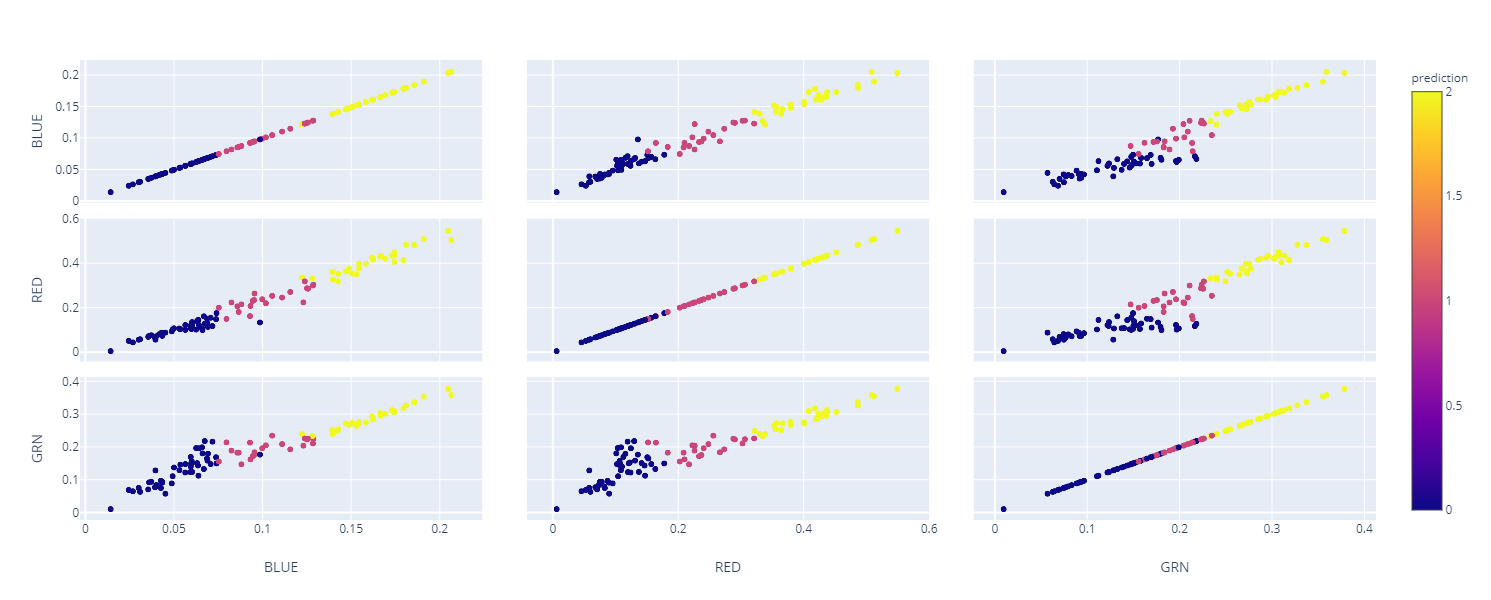

In [13]:
px.scatter_matrix(data_frame=vegi1Scatter_pd
                  , dimensions=vegi1InputCols
                  , color="prediction"
                 )

In [14]:
(xCol,yCol,zCol) = tuple(vegi1InputCols)
fig = px.scatter_3d(vegi1Scatter_pd, x=xCol, y=yCol, z=zCol, color='prediction').show()

__Show the Categoriesed areas in an Image next to the True Color Image (TCI)__
- open both the TCI and the Mask
- overlay the k-means cluster categories, over the tci (albeit not leaving much to see)
- overlay the Mask over the TCI, demonstrating that it doesn't overlay very well at all

In [15]:
from PIL import Image, ImageDraw
def open_image(path, mode = None, cropbox = None, verbose = True):
    if verbose:
        print(path)
    img = Image.open(path)
    if cropbox is not None:
        img = img.crop(cropbox)
    if mode is not None:
        img = img.convert(mode)
    if verbose:
        print("Format: {0}\nSize: {1}\nMode: {2}".format(img.format, img.size, img.mode))
        (width, height) = img.size
        print('width:',width,'height:',height)
    return img

In [16]:
tciFilePath = 'E:\\work\\canecrushers\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\timeseries\\7680-10240-TCI-2019-08-09.png'
tci = open_image(tciFilePath, mode='RGB')

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\timeseries\7680-10240-TCI-2019-08-09.png
Format: None
Size: (512, 512)
Mode: RGB
width: 512 height: 512


In [17]:
vegiClustered_df = vegi1ClusteredDF.select('x','y','prediction').toPandas()
vegiClustered_df.head(2)

,x,y,prediction
0,0,0,0
1,0,1,0


In [18]:
green_np = np.array([0,255,0], dtype='uint8')
blue_np = np.array([0,0,255], dtype='uint8')
red_np = np.array([255,0,0], dtype='uint8')

def overlayPredictionImage(df, tci, overlay_colour):
    """ overlay harvest predition onto image
        df - pandas dataframe with 'x', 'y' and 'prediction' integer columns
        tci - rgb image
        overlay_colour - list of np.array([r,g,b], dtype='uint8') representing the colours to overlay
        return a numpy array x by y by [r,g,b]
    """
    result = np.array(tci)
    for row in df.itertuples():
        result[row.y,row.x] = overlay_colour[row.prediction]
    return result

imgnp = overlayPredictionImage(vegiClustered_df, tci, [green_np, blue_np, red_np])
imgnp.shape

(512, 512, 3)

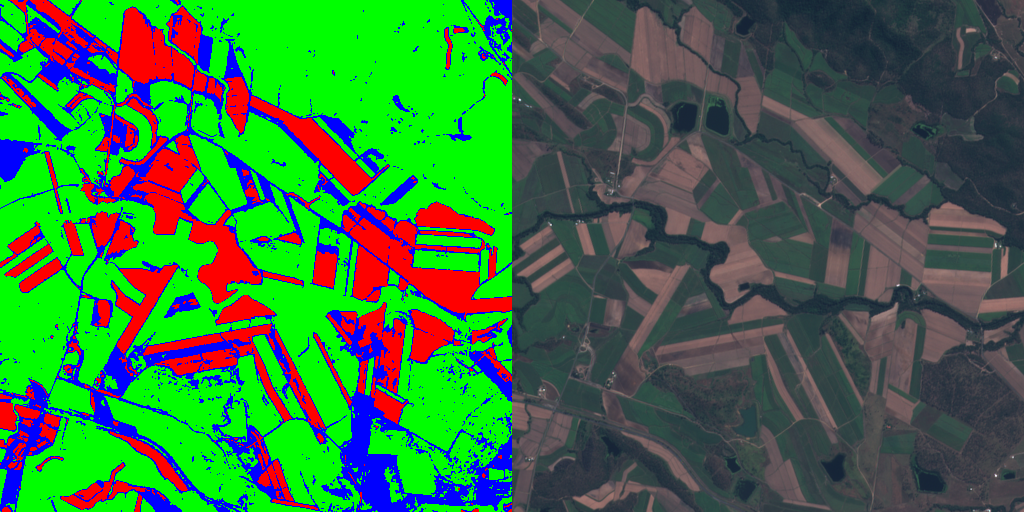

In [19]:
clusterImg = Image.fromarray(np.hstack((imgnp, np.array(tci))))
clusterImg

In [20]:
featrelist = '_'.join(vegi1InputCols)
clusterImgFilePath = f'E:\\work\\canecrushers\\phase-01\\k-means_clusters_{featrelist}.png'
clusterImg.save(clusterImgFilePath)
print(f'save image to {clusterImgFilePath}')

save image to E:\work\canecrushers\phase-01\k-means_clusters_BLUE_RED_GRN.png
